In this Notebook, we will do an implementation of the spacing and O-C diagrams as a first draft for a paper.

In [1]:
import numpy as np # for maths 
import matplotlib.pyplot as plt # for plotting 

from astropy.timeseries import LombScargle

import scipy.signal as sps

from maser import maser

from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

from helper_functions import get_events, group_events, get_oc, get_peaks, get_a, get_P_p


In [2]:
# Defining variables 

# Stellar parameters
M_s = 0.5 # Star mass (solar masses) 
R_s = 0.75 # Star radius (solar radii) 
P_s = 4.86 # Star rotation period (days) 
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) 
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) 
beta = 20 # Star magnetic obliquity (degrees)
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1)

# Planet parameters
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees)
lam = 0 # Planet projected spin-orbit angle (degrees) 
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) 

# Emission parameters
f = 10 # Emission observing frequency (MHz) 
alpha = 75 # Emission cone opening angle (degrees) 
dalpha = 5 # Emission cone thickness (degrees)

# Extra stuff 
P_p = 8.4630351 # AU Mic b period (days)
P_p = 3.36 # for plotting

# invert P_p = 2 * jnp.pi * ((a * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day
# to get a
a = get_a(P_p, M_s, R_s)
print('Semimajor axis: %.2f AU' % a)

Semimajor axis: 9.99 AU


In [8]:
times = np.linspace(0, 730, 40000) # Array of observation times to compute (days) - running for 2 years

# Calling MASER
visibility_North, visibility_South = maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)

# get southern centres and durations
centres_S, durations_S = get_events(times, visibility_South)
group_centres_S, group_durations_S = group_events(centres_S)

# get northern centres and durations
centres_N, durations_N = get_events(times, visibility_North)
group_centres_N, group_durations_N = group_events(centres_N)

(0.0, 30.0)

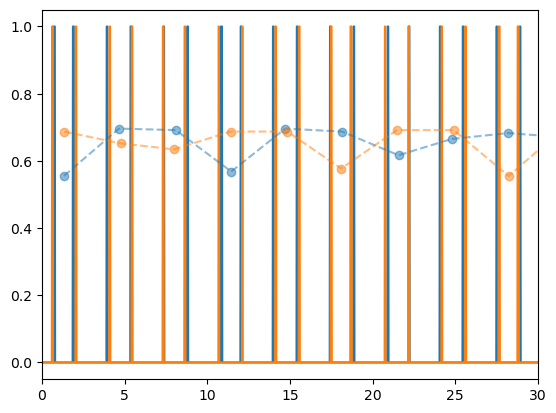

In [4]:
plt.plot(times,visibility_North,color='C0')
plt.plot(times,visibility_South,color='C1')

plt.plot(group_centres_N[::2], group_durations_N[::2]/np.max(group_durations_N), '--oC0',alpha=0.5)
plt.plot(group_centres_S[::2], group_durations_S[::2]/np.max(group_durations_S), '--oC1',alpha=0.5)

plt.xlim(0,30)

How does the spacing vary with period?

In [5]:
planet_periods = np.geomspace(0.5*P_s, 4*P_s, 100)

spacings = np.zeros((len(planet_periods),2))

for j, pp in enumerate(tqdm(planet_periods)):
    
    aa = get_a(pp, M_s, R_s)
    
    # call maser
    visibility_North, visibility_South = maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, aa, i_p, lam, phi_p0, f, alpha, dalpha, times)

    # identify events
    centres_S, durations_S = get_events(times, visibility_South)
    group_centres_S, group_durations_S = group_events(centres_S)

    centres_N, durations_N = get_events(times, visibility_North)
    group_centres_N, group_durations_N = group_events(centres_N)

    # find whether 0 or 1 element has smaller duration
    short_n = np.argmin(group_durations_N[:2])
    xn = group_centres_N[short_n::2]

    short_s = np.argmin(group_durations_S[:2])
    xs = group_centres_S[short_s::2]

    spacings[j,0] = np.mean(np.diff(xn))
    spacings[j,1] = np.mean(np.diff(xs))



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 70.12it/s]


Text(0, 0.5, 'Spacing (days)')

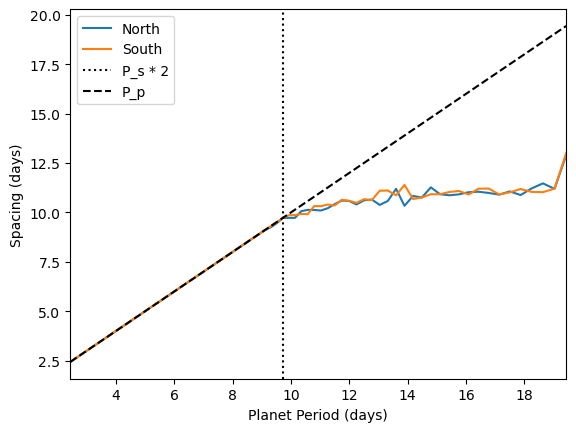

In [6]:
plt.plot(planet_periods, spacings[:,0], label='North')
plt.plot(planet_periods, spacings[:,1], label='South')
plt.axvline(P_s*2, color='k', ls=':', label='P_s * 2')
plt.plot(planet_periods,planet_periods, color='k', ls='--', label='P_p')
plt.legend()

plt.xlim(planet_periods[0], planet_periods[-1])
plt.xlabel('Planet Period (days)')
plt.ylabel('Spacing (days)')

So it looks like the mean spacing exactly follows the planet period until 2 times the stellar rotation period, when it decouples - possibly because the pair spacing is changing and we lose track of it then.

Let's look at the deviations from this mean period - do they encode the stellar rotation?

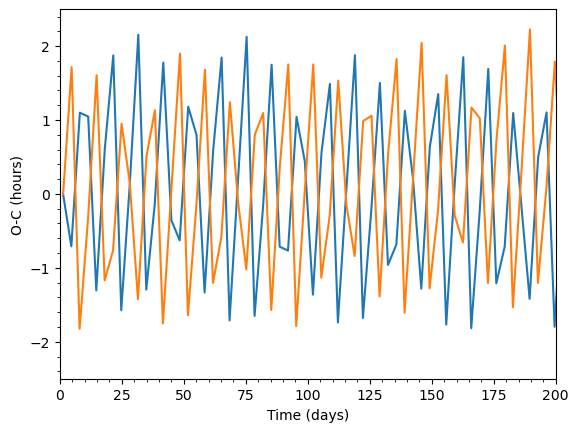

In [22]:
## Mean spacing for O-C diagram

# north
oc_n = get_oc(group_centres_N[::2])*24
xn = group_centres_N[::2]
# south
oc_s = get_oc(group_centres_S[::2])*24
xs = group_centres_S[::2]

# Plotting O-C diagram
plt.plot(xn, oc_n, 'C0-')
plt.plot(xs, oc_s, 'C1-')

plt.xlabel('Time (days)')
plt.ylabel('O-C (hours)')

plt.xlim(0,200) # if you zoom out there is a slight trend - fix this!
plt.ylim(-2.5,2.5)
plt.minorticks_on()

Looks pretty sinusoidal to me! 

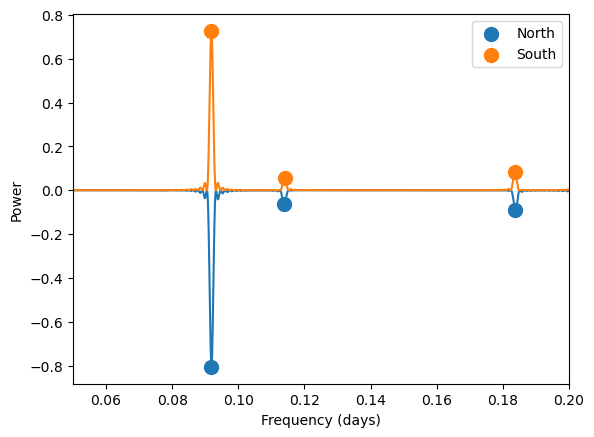

In [23]:
frequencies = np.geomspace(1/20,1/5,10000)
periods = 1/frequencies

ls_s = LombScargle(xs, oc_s)
power_s = ls_s.power(frequencies)

ls_n = LombScargle(xn, oc_n)
power_n = ls_n.power(frequencies)

peaks_s, amps_s = get_peaks(frequencies, power_s)
peaks_n, amps_n = get_peaks(frequencies, power_n)

plt.plot(frequencies, -power_n, 'C0-')
plt.plot(frequencies, power_s, 'C1-')

plt.scatter(peaks_n, -amps_n, c='C0', s=100,label='North')
plt.scatter(peaks_s, amps_s, c='C1', s=100,label='South')
plt.xlim(frequencies.min(),frequencies.max())

plt.xlabel('Frequency (days)')
plt.ylabel('Power')
plt.legend()

In [24]:
stellar_periods = np.geomspace(0.5*P_p, 4*P_p, 100)

peaks_n = np.zeros((len(stellar_periods),3))
amps_n = np.zeros((len(stellar_periods),3))

peaks_s = np.zeros((len(stellar_periods),3))
amps_s = np.zeros((len(stellar_periods),3))

for j, ps in enumerate(tqdm(stellar_periods)):
    
    # call maser
    visibility_North, visibility_South = maser(M_s, R_s, ps, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)

    # identify events
    centres_S, durations_S = get_events(times, visibility_South)
    group_centres_S, group_durations_S = group_events(centres_S)

    centres_N, durations_N = get_events(times, visibility_North)
    group_centres_N, group_durations_N = group_events(centres_N)

    # find whether 0 or 1 element has smaller duration
    short_n = np.argmin(group_durations_N[:2])
    xn = group_centres_N[short_n::2]

    short_s = np.argmin(group_durations_S[:2])
    xs = group_centres_S[short_s::2]

    # nyquist sampling
    min_period = 2.1*np.median(np.abs(np.diff(xn)))
    max_period = 5*P_p

    # get o-c
    oc_n = get_oc(xn)*24
    oc_s = get_oc(xs)*24

    # lomb-scargle
    frequencies = np.geomspace(1/(min_period),1/max_period,5000)
    periods = 1/frequencies

    ls_s = LombScargle(xs, oc_s)
    power_s = ls_s.power(frequencies)
    peaks_s[j,:], amps_s[j,:] = get_peaks(frequencies, power_s)

    ls_n = LombScargle(xn, oc_n)
    power_n = ls_n.power(frequencies)
    peaks_n[j,:], amps_n[j,:] = get_peaks(frequencies, power_n)



100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


Text(0.5, 0, 'Stellar Period (days)')

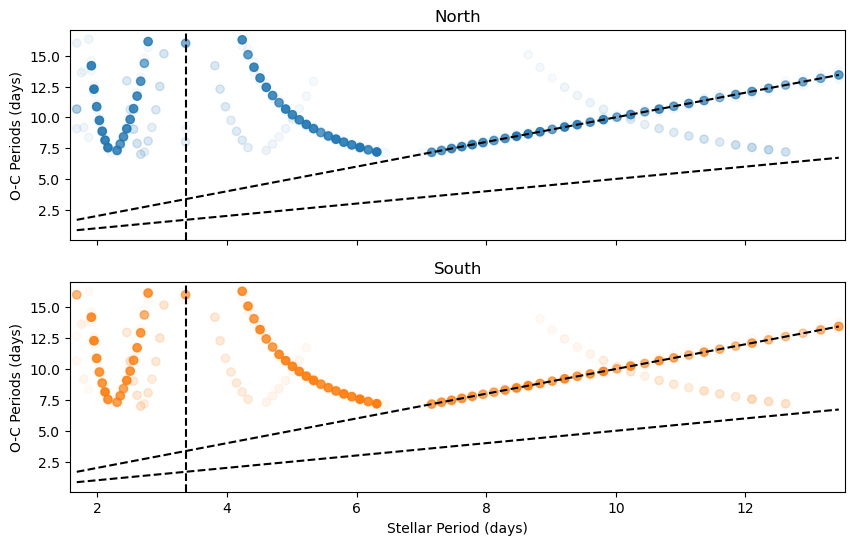

In [25]:
period_peaks_n = 1/peaks_n
period_peaks_s = 1/peaks_s

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True)

for j in range(3):
    ax1.scatter(stellar_periods, period_peaks_n[:,j], alpha=amps_n[:,j],c='C0')
    ax2.scatter(stellar_periods, period_peaks_s[:,j], alpha=amps_s[:,j],c='C1')

ax1.set_title('North')
ax2.set_title('South')

# plt.axis('equal')
for ax in (ax1, ax2):
    ax.plot(stellar_periods, stellar_periods, 'k--')
    ax.plot(stellar_periods, stellar_periods/2, 'k--')
    ax.axvline(P_p, c='k', ls='--')
    ax.set_xlim(stellar_periods.min()-0.1,stellar_periods.max()+0.1)
    ax.set_ylabel('O-C Periods (days)')

ax2.set_xlabel('Stellar Period (days)')

The periods of maximum power are basically the period of the stellar rotation and its subharmonic; and aliases and a resonance with the planet period.